## Categorical Perception: A Groundwork for Deep Learning
#### Laurent Bonnasse-Gahot & Jean-Pierre Nadal
Python notebook for the two dimensional toy example, Section 3.1.2, reproducing Figure 2 of the paper.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# for reproducibility
SEED = 1
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rc={'font.size': 11, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('ticks')

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from scipy.stats import multivariate_normal

In [4]:
if not os.path.exists('fig'):
    os.makedirs('fig')

In [5]:
n_samples = 500

mu1 = np.array([-0.5,-0.5])
mu2 = -mu1
sig1 = np.array([[0.5, 0.0],[0.0, 0.5]])
sig2 = sig1

x_train = np.vstack((np.random.multivariate_normal(mu1, sig1, size=int(.5*n_samples)),
                     np.random.multivariate_normal(mu2, sig2, size=int(.5*n_samples))))
y_train = np.zeros(n_samples, dtype=np.int)
y_train[int(.5*n_samples):] = 1

In [6]:
idx_1 = y_train == 0
idx_2 = y_train == 1

In [7]:
initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)

input_shape = (2,)

n_hid = 128

def create_model(training=None):
    input_x = Input(shape=input_shape)
    x = Dense(n_hid, activation='relu', bias_initializer=initializer)(input_x)
    x = Dropout(0.2)(x, training=training)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input_x, x)

model = create_model(training=None)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1)
model_early = tf.keras.models.clone_model(model)
model_early.set_weights(model.get_weights())
model.fit(x_train, y_train, epochs=3)
model_middle = tf.keras.models.clone_model(model)
model_middle.set_weights(model.get_weights())
model.fit(x_train, y_train, epochs=16)
model_late = model

16/16 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.4911
Epoch 1/3
16/16 [==============================] - 0s 1ms/step - loss: 0.6102 - accuracy: 0.7600
Epoch 2/3
16/16 [==============================] - 0s 1ms/step - loss: 0.5500 - accuracy: 0.8040
Epoch 3/3
16/16 [==============================] - 0s 1ms/step - loss: 0.5004 - accuracy: 0.8100
Epoch 1/16
16/16 [==============================] - 0s 1ms/step - loss: 0.4565 - accuracy: 0.8420
Epoch 2/16
16/16 [==============================] - 0s 1ms/step - loss: 0.4279 - accuracy: 0.8400
Epoch 3/16
16/16 [==============================] - 0s 2ms/step - loss: 0.4020 - accuracy: 0.8340
Epoch 4/16
16/16 [==============================] - 0s 1ms/step - loss: 0.3867 - accuracy: 0.8420
Epoch 5/16
16/16 [==============================] - 0s 1ms/step - loss: 0.3679 - accuracy: 0.8420
Epoch 6/16
16/16 [==============================] - 0s 1ms/step - loss: 0.3649 - accuracy: 0.8520
Epoch 7/16
16/16 [================

In [8]:
def compute_loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

def compute_grad_desc(x, layer_output_target, learning_rate, activation_model):
    n_steps = 1000
    for _ in range(n_steps):
        with tf.GradientTape() as tape:
            tape.watch(x)
            layer_output = activation_model(x, training=False)
            loss = compute_loss(tf.constant(layer_output_target), layer_output)
            grads = tape.gradient(loss, x)
            x = x - learning_rate * grads
    return x.numpy().squeeze()

def compute_estimates(model, xgrid):
    activation_model = Model(inputs=model.input, 
                             outputs=model.layers[2].output)
    n_trials = 100
    activity_target = np.array([activation_model(np.repeat(xgrid, n_trials, axis=0), training=True).numpy()])
    activity_target = activity_target.reshape(n_stims, n_trials, n_hid)
    learning_rate = 10.0
    xhat = []
    for idx_stim in range(n_stims):
        layer_output_target = activity_target[idx_stim, :, :]
        xinit = tf.Variable([xgrid[idx_stim]]*n_trials)
        xhat.append(compute_grad_desc(xinit, layer_output_target, learning_rate, activation_model))
    return xhat

In [9]:
# code from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [10]:
n_samples = 5
xmin, xmax = -1., 1.
ymin, ymax = -1., 1.
x = np.linspace(xmin, xmax, n_samples)
y = np.linspace(ymin, ymax, n_samples)

xgrid = []
for idx1 in range(n_samples):
    for idx2 in range(n_samples):
        xgrid.append([x[idx1], y[idx2]])
xgrid = np.array(xgrid)

n_stims = xgrid.shape[0]

xx, yy = np.meshgrid(np.linspace(-2, 2, 50), 
                     np.linspace(-2, 2, 50))
rv1 = multivariate_normal(mean=mu1, cov=sig1)
rv2 = multivariate_normal(mean=mu2, cov=sig2)
px = lambda x : .5*(rv1.pdf(x) + rv2.pdf(x))

xhat_early = compute_estimates(model_early, xgrid)
xhat_middle = compute_estimates(model_middle, xgrid)
xhat_late = compute_estimates(model, xgrid)

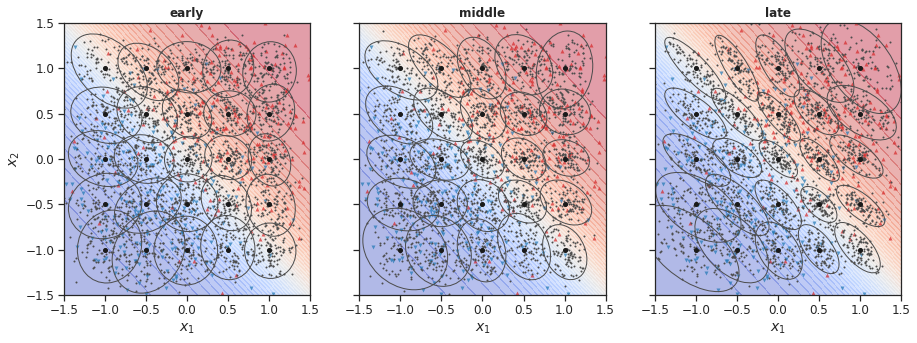

In [11]:
def plot_results(xhat, ax):
    ax.contourf(xx, yy, .5*rv2.pdf(np.dstack((xx,yy)))/px(np.dstack((xx,yy))),
                 cmap='coolwarm', alpha=0.4, levels=50, zorder=-2)
    ax.plot(x_train[idx_1,0], x_train[idx_1,1], marker='v', ls='', c='tab:blue', 
             markeredgecolor='None', markersize=4, alpha=0.7, zorder=-1)
    ax.plot(x_train[idx_2,0], x_train[idx_2,1], marker='^', ls='', c='tab:red',
             markeredgecolor='None', markersize=4, alpha=0.7, zorder=-1)
    for idx_stim in range(n_stims):
        confidence_ellipse(xhat[idx_stim][:, 0], xhat[idx_stim][:, 1], ax, n_std=2.0, edgecolor='0.3', ls='-')
    ax.plot(xgrid[:, 0], xgrid[:, 1], 'o', c='0.1', markersize=4, zorder=1)
    for idx_stim in range(n_stims):
        ax.plot(xhat[idx_stim][:, 0], xhat[idx_stim][:, 1], 'o', c='0.3',
                 markeredgecolor='None', markersize=2, zorder=0)

fh = plt.figure(figsize=(15, 5))
axs = fh.subplots(1, 3, sharex=True, sharey=True)
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
ax = axs[0]
plot_results(xhat_early, ax)
ax.set_title('early', fontweight='bold')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax = axs[1]    
plot_results(xhat_middle, ax)
ax.set_title('middle', fontweight='bold')
ax.set_xlabel('$x_1$')
ax = axs[2]   
plot_results(xhat_late, ax)
ax.set_title('late', fontweight='bold')
ax.set_xlabel('$x_1$')
plt.show()

fh.savefig('fig/gaussian2d_mlp_dynamics.pdf', bbox_inches='tight')